#**前置作業**

##引入模組

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Conv1D, LSTM, MaxPooling1D, Flatten, Dropout
from sklearn.svm import SVR
from keras.models import load_model


##定義參數

In [ ]:
# 檔案、資料夾路徑參數
gdrive_path = '/content/drive'
project_folder_path = '/content/drive/MyDrive/Inundation_Forcasting/'
filename = 'SD.xlsx'
data_source_path = project_folder_path + 'data/'
data_source = data_source_path + filename
weights_path = project_folder_path + 'weights/'
output_path = project_folder_path + 'outputs/'

# 資料參數
num_events = 5

# 模型參數
epochs = 50
batch_size = 16
learning_rate = 0.001
loss_fn = 'mse'
dropout_rate = 0.2


##連接雲端硬碟

In [ ]:
from google.colab import drive
drive.mount(gdrive_path)

Mounted at /content/drive


#**副程式**

##資料處理工具

In [ ]:
# 載入資料
def load_data(path):
    wb = openpyxl.load_workbook(path, data_only=True)
    events = [wb[sheetname] for sheetname in wb.sheetnames]
    for i in range(len(events)):
        events[i] = pd.DataFrame(get_values(events[i]))
    return events

# 取得資料值並儲存為列表
def get_values(sheet):
    arr = [] 
    for row in sheet:
        temp = []  
        for column in row:
            temp.append(column.value)
        arr.append(temp)
    return arr

# 正規化資料(將資料範圍限縮在0~1之間，防止資料大小差異過大，影響模型訓練)
def normalize(data):
    normalized_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return normalized_data

# 反正規化資料(將正規化的資料還原，用於結果呈現)
def denormalize(data, original):
    denormalized_data = data * (np.max(original) - np.min(original)) + np.min(original)
    return denormalized_data

# 分割訓練及測試資料
def split_data(nX, nY, b1, b2):
    X_train = nX[:b1]
    Y_train = nY[:b1]
    X_val = nX[b1:b2]
    Y_val = nY[b1:b2]
    X_test = nX[b2:]
    Y_test = nY[b2:]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

# 產生資料及標籤
def create_sequences(events):
    df = pd.concat(events, ignore_index=True)
    ref = df.iloc[:, :(len(df.columns)-1)]
    pred = df.iloc[:, (len(df.columns)-1)]

    X, Y = [], []
    num_data = len(ref)
    for i in range(num_data):
        seq = ref.iloc[i, :]
        label = pred[i]
        X.append(seq)
        Y.append(label)

    X, Y = np.array(X), np.array(Y)
    X = X.reshape(X.shape[0], X.shape[1], 1).astype('float32')
    Y = Y.reshape(Y.shape[0], 1).astype('float32')

    return X, Y


##定義模型

###LSTM

In [ ]:
class My_LSTM():
  def __init__(self):
    self.name = 'My_LSTM'

  def create_model(self, steps, features):
    model = Sequential(name="My_LSTM")
    model.add(LSTM(64, return_sequences=True, input_shape=(steps, features)))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(features))
    return model

  def train(self, data, show_training_history=True):
    X, Y, X_train, Y_train, X_val, Y_val, X_test, Y_test = data
    model = self.create_model(X_train.shape[1], X_train.shape[2])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss_fn)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val))
    if show_training_history:
      plt.plot(history.history['loss'], label='train')
      plt.plot(history.history['val_loss'], label='val')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()
    return model

  def save_model(self, model, filename):
    path = weights_path + filename + '.h5'
    model.save(path)
    print('training weights saved in ' + path)

  def predict(self, data, filename):
    X, Y, X_train, Y_train, X_val, Y_val, X_test, Y_test = data
    model = load_model(weights_path + filename + '.h5')
    Y_predict = model.predict(X_test)
    Y_predict = denormalize(Y_predict, Y)
    Y_test = denormalize(Y_test, Y)
    return (Y_test, Y_predict)

  def save_result(self, result, filename, show=True):
    Y_test, Y_predict = result
    plt.plot(Y_test, color = 'red', label = 'Real Depth') 
    plt.plot(Y_predict, color = 'blue', label = 'Predicted Depth') 
    plt.title('Depth Prediction')
    plt.xlabel('Time')
    plt.ylabel('Depth (cm)')
    plt.legend()
    path = output_path + filename + '.png'
    plt.savefig(path)
    print('Prediction result saved in ' + path)
    if show:
      plt.show()


#**主程式**

[1, 4, 2, 3, 0]
Epoch 1/50
11/11 [==============================] - 12s 142ms/step - loss: 0.1174 - val_loss: 0.1038
Epoch 2/50
11/11 [==============================] - 0s 15ms/step - loss: 0.0737 - val_loss: 0.1416
Epoch 3/50
11/11 [==============================] - 0s 14ms/step - loss: 0.0562 - val_loss: 0.0651
Epoch 4/50
11/11 [==============================] - 0s 14ms/step - loss: 0.0501 - val_loss: 0.0974
Epoch 5/50
11/11 [==============================] - 0s 13ms/step - loss: 0.0454 - val_loss: 0.0885
Epoch 6/50
11/11 [==============================] - 0s 14ms/step - loss: 0.0506 - val_loss: 0.0820
Epoch 7/50
11/11 [==============================] - 0s 13ms/step - loss: 0.0447 - val_loss: 0.0807
Epoch 8/50
11/11 [==============================] - 0s 13ms/step - loss: 0.0502 - val_loss: 0.0605
Epoch 9/50
11/11 [==============================] - 0s 13ms/step - loss: 0.0446 - val_loss: 0.0491
Epoch 10/50
11/11 [==============================] - 0s 13ms/step - loss: 0.0524 - val_loss

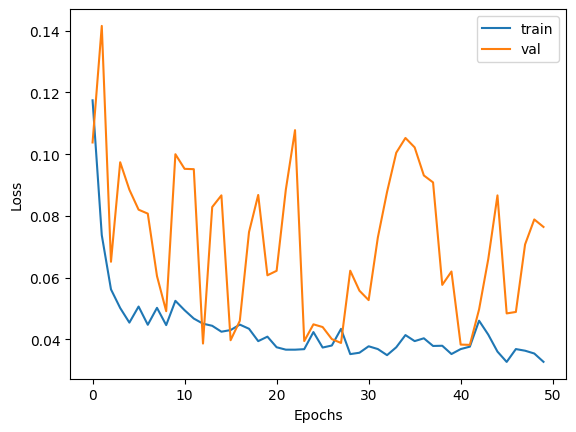

training weights saved in /content/drive/MyDrive/Inundation_Forcasting/weights/SD_training_v2.h5
2/2 [==============================] - 1s 9ms/step
Prediction result saved in /content/drive/MyDrive/Inundation_Forcasting/outputs/SD_training_v2.png


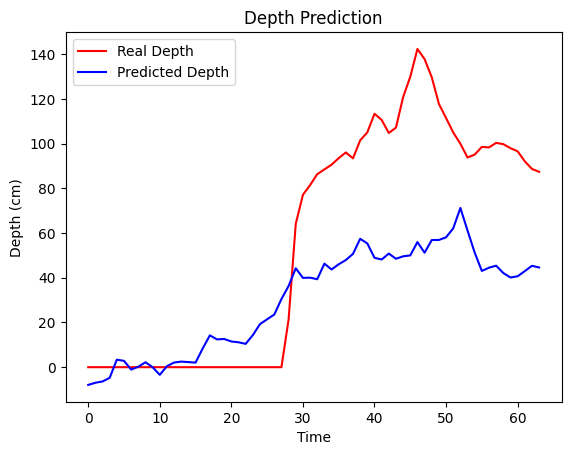

In [ ]:
import random as rd

events = load_data(data_source)

order = list(range(num_events))
rd.shuffle(order)
print(order)
events = [events[i] for i in order]

b1 = sum([len(events[i]) for i in range(len(events)-2)])
b2 = b1 + len(events[-2])

X, Y = create_sequences(events)
nX, nY = normalize(X), normalize(Y)

X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(nX, nY, b1, b2)
data = X, Y, X_train, Y_train, X_val, Y_val, X_test, Y_test

lstm = My_LSTM()

weights_filename = 'SD_training_v2'
output_filename = 'SD_training_v2'

model = lstm.train(data)
lstm.save_model(model, weights_filename)

result = lstm.predict(data, weights_filename)
lstm.save_result(result, output_filename)
